In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

from cfollmer.objectives import log_g, relative_entropy_control_cost, relative_entropy_control_cost_direct
from cfollmer.sampler_utils import FollmerSDE
import numpy as np

from tqdm.notebook import tqdm

# from torch import _vmap_internal

device = "cuda" if torch.cuda.is_available() else "cpu"

## Variance and Mean Matching bug Here

Check out ln_prior there I am tweaking $\sigma_w$ Ive set the log_likelihood to be 0 this way our algorithm should be trying to have as target the prior . For some reason the neural net is completely unable to match the variance I am specifying I have gone from very low to very high and the method is unable to do anhything to fit the target variance. For a sufficiently small $\Delta t$ we should be able to do this, standard VI is able to do this, so theres some sort of bug / issue here. 

UPDATE: Atm its not even matching the mean hardcoded it to 10 and nothings happening ?? whats going on here?

In [131]:
# TODO: Why is changing σ_w doing nothing ??
def ln_prior(Θ, σ_w=0.1):
    """
    Prior for means in Bayesian GMM
    """
    return -0.5 * ((Θ)**2).sum(axis=1) / σ_w**2

In [132]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim =  2

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 100

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [133]:
relative_entropy_control_cost_direct(sde, Θ_0, ln_prior, γ=1.0, device=device)

tensor(108.1166, device='cuda:0', grad_fn=<MeanBackward0>)

In [134]:
γ = 1
Δt=0.005
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.001, weight_decay =0.01)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 1000

train = True
if train:
    for i in tqdm(range(num_steps)):
        optimizer.zero_grad()

        if isinstance(optimizer, torch.optim.LBFGS):
            def closure():
                loss = relative_entropy_control_cost_direct(
                    sde, Θ_0.float(),
                    ln_prior, γ=γ
                )
                optimizer.zero_grad()
                loss.backward()
                return loss

            optimizer.step(closure)
            losses.append(closure().item())
        else:
            loss = relative_entropy_control_cost_direct(
                sde, Θ_0,
                ln_prior, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            losses.append(loss.item())

200


  0%|          | 0/1000 [00:00<?, ?it/s]

In [135]:
losses

[116.57444763183594,
 98.38278198242188,
 91.76437377929688,
 103.6418228149414,
 99.84817504882812,
 130.2826690673828,
 100.73504638671875,
 99.885498046875,
 105.96541595458984,
 99.23228454589844,
 91.07349395751953,
 87.03157806396484,
 101.2237319946289,
 86.65771484375,
 85.88850402832031,
 86.80027770996094,
 95.61183166503906,
 86.42330169677734,
 97.85296630859375,
 86.44664764404297,
 80.98892211914062,
 84.80622863769531,
 80.10204315185547,
 83.84493255615234,
 107.10620880126953,
 91.97122955322266,
 79.79916381835938,
 102.8475341796875,
 85.60527038574219,
 82.58155822753906,
 85.99223327636719,
 91.58992004394531,
 77.80525207519531,
 107.12776184082031,
 90.5850601196289,
 93.50067138671875,
 73.38700866699219,
 65.66529083251953,
 92.61837768554688,
 86.25468444824219,
 94.70526123046875,
 79.79014587402344,
 83.13435363769531,
 64.36449432373047,
 73.24236297607422,
 79.45049285888672,
 79.14836120605469,
 78.27677917480469,
 74.58570098876953,
 90.66765594482422,
 

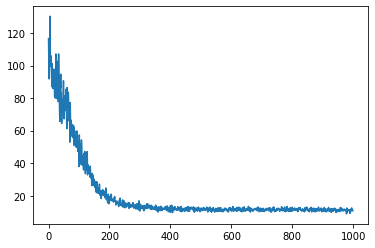

In [136]:
plt.plot(losses[:])

In [137]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([200, 100, 2])

In [138]:
# Mannualy doing one step of Euler

Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

In [139]:
Θ_1 = Θ_1.reshape(100,2)

(array([ 3.,  0.,  5., 15., 26., 15., 18.,  8.,  8.,  2.]),
 array([-0.66365224, -0.5369234 , -0.41019464, -0.2834658 , -0.156737  ,
        -0.0300082 ,  0.09672061,  0.22344942,  0.35017824,  0.47690704,
         0.60363585], dtype=float32),
 <a list of 10 Patch objects>)

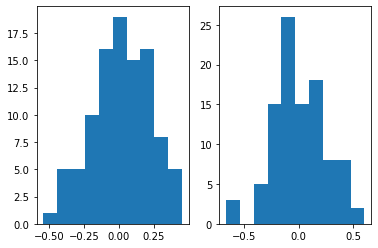

In [140]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.hist(Θ_1[:,0].flatten().cpu().detach().numpy())
ax2.hist(Θ_1[:,1].flatten().cpu().detach().numpy())

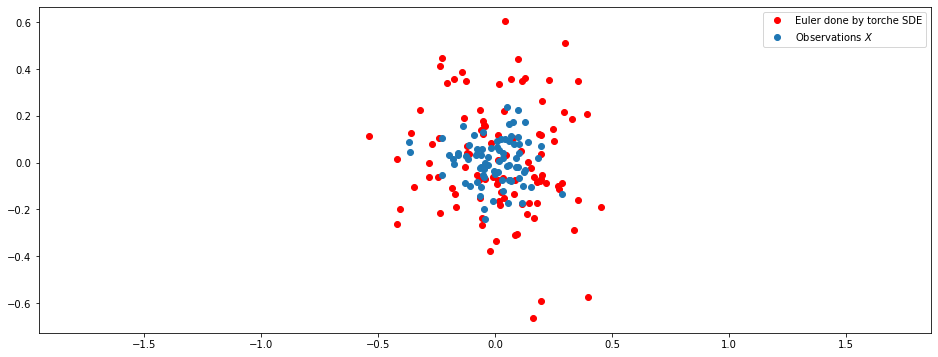

In [142]:
fig, ax_1 = plt.subplots(1, 1, figsize=(16, 6))
Θ_plot = Θ_1.cpu().detach() #.reshape(50*3,2)

# Θ_plot2 = Θ_2.cpu().detach() 
X_scaled = torch.normal(0,0.1, (80, 2)).detach().cpu() 


ax_1.plot(Θ_plot[:, 0], Θ_plot[:, 1], 
         linestyle='none', 
         marker='o', color="red", label="Euler done by torche SDE")

# ax_1.plot(Θ_plot2[:, 0], Θ_plot2[:, 1], 
#          linestyle='none', 
#          marker='o', color="blue", label="Euler done manually")

ax_1.plot(X_scaled[:, 0], X_scaled[:, 1], 
         linestyle='none', 
         marker='o', label="Observations $X$")

ax_1.legend()
ax_1.axis('equal');